In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#Check the type of data we can find within measurement
inspector=inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
#Check the type of data we can find within station
inspector=inspect(engine)

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
# Recent date: the latest
latest_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first().date
latest_date

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_year = dt.date(2017,8,23) - dt.timedelta(days=365)
previous_year

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
year_precipitation = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= previous_year).\
    filter(measurement.date <= latest_date).\
    order_by(measurement.date).all()

year_precipitation

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(year_precipitation, columns=['Date', 'Precipitation'])

In [15]:
precipitation_df = precipitation_df.set_index('Date')

In [16]:
precipitation_df = precipitation_df.sort_index(ascending=True)
precipitation_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


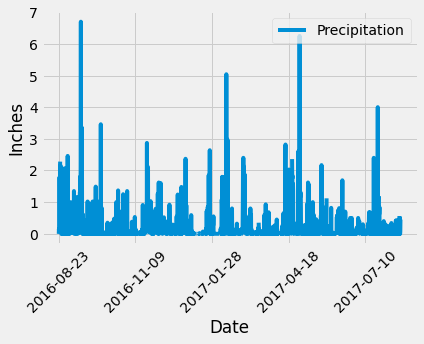

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(use_index=True, x_compat=True, y='Precipitation')
plt.ylabel("Inches")
plt.xticks(rotation = 45)
plt.legend(['Precipitation'], loc='upper right')

#Save the plot as an image for easy reference 
plt.savefig("Images/DateVSPrecipitationPlot.png")

plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.id).count()
station_count

9

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement.station,
                     func.count(measurement.station)).\
                     group_by(measurement.station).\
                     order_by(func.count(measurement.station).desc()).\
                     all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query for the most active station
top_station = most_active_stations[0][0]
top_station

'USC00519281'

In [23]:
# Lowest Temperature
lowest_temp = session.query(measurement.tobs).\
    filter(measurement.station == top_station).\
    order_by(measurement.tobs).first()
lowest_temp

(54.0,)

In [24]:
# Highest Temperature
highest_temp = session.query(measurement.tobs).\
    filter(measurement.station == top_station).\
    order_by(measurement.tobs.desc()).first()
highest_temp

(85.0,)

In [25]:
# Average Temperature
avg_temp = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == top_station).all()
avg_temp

[(71.66378066378067,)]

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(measurement.station, measurement.date, measurement.tobs).\
    filter(measurement.station == top_station).\
    filter(measurement.date > previous_year).\
    order_by(measurement.date.desc()).all()
temp_obs

[('USC00519281', '2017-08-18', 79.0),
 ('USC00519281', '2017-08-17', 76.0),
 ('USC00519281', '2017-08-16', 76.0),
 ('USC00519281', '2017-08-15', 77.0),
 ('USC00519281', '2017-08-14', 77.0),
 ('USC00519281', '2017-08-13', 77.0),
 ('USC00519281', '2017-08-06', 83.0),
 ('USC00519281', '2017-08-05', 82.0),
 ('USC00519281', '2017-08-04', 77.0),
 ('USC00519281', '2017-07-31', 76.0),
 ('USC00519281', '2017-07-30', 81.0),
 ('USC00519281', '2017-07-29', 82.0),
 ('USC00519281', '2017-07-28', 81.0),
 ('USC00519281', '2017-07-27', 76.0),
 ('USC00519281', '2017-07-26', 75.0),
 ('USC00519281', '2017-07-25', 77.0),
 ('USC00519281', '2017-07-24', 75.0),
 ('USC00519281', '2017-07-23', 82.0),
 ('USC00519281', '2017-07-22', 77.0),
 ('USC00519281', '2017-07-21', 77.0),
 ('USC00519281', '2017-07-20', 77.0),
 ('USC00519281', '2017-07-19', 76.0),
 ('USC00519281', '2017-07-18', 76.0),
 ('USC00519281', '2017-07-17', 76.0),
 ('USC00519281', '2017-07-16', 80.0),
 ('USC00519281', '2017-07-15', 80.0),
 ('USC005192

In [27]:
# Convert the series into a dataframe for plotting
temp_obs_df = pd.DataFrame(temp_obs, columns = ['Station', 'Date', 'Temperature'])
temp_obs_df.head()

,Station,Date,Temperature
0,USC00519281,2017-08-18,79.0
1,USC00519281,2017-08-17,76.0
2,USC00519281,2017-08-16,76.0
3,USC00519281,2017-08-15,77.0
4,USC00519281,2017-08-14,77.0


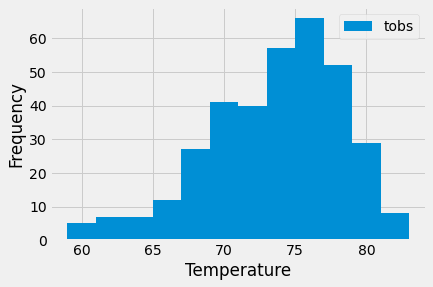

In [28]:
# Plot histogram
plt.hist(temp_obs_df['Temperature'],12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["tobs"])

#Save the plot as an image for easy reference 
plt.savefig("Images/TemperatureVSFrequencyHistogram.png")

plt.show()

# Close session

In [29]:
# Close Session
session.close()